# Otimização de hiperparâmetros e avaliação final

## Setup

In [49]:
!pip install pandas plotly matplotlib seaborn scikit-learn xgboost optuna hyperopt setuptools nbformat

In [50]:
# Módulo para leitura e manipulação dos dados
import pandas as pd

# Módulo para manipulação de arrays e matrizes
import numpy as np

# Módulos para visualização de dados e plotagem de gráficos
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

# Módulos específicos da sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import svm
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif

# Biblioteca com algoritmos específicos de machine learning
from xgboost import XGBClassifier

# Módulo para balanceamento de classes
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

import optuna
from optuna.visualization import plot_optimization_history, plot_slice, plot_contour, plot_parallel_coordinate, plot_param_importances
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

## Carregamento dos dados

Dataset pré-processado no notebook [t1-spot-checking.ipynb](./t1-spot-checking.ipynb)

---
Dataset obtido em https://www.kaggle.com/datasets/thedevastator/higher-education-predictors-of-student-retention/data

Original: https://zenodo.org/records/5777340#.Y7FJotJBwUE

In [51]:
data = pd.read_csv("../data/clean-dataset.csv")

In [52]:
# Separa atributos preditivos e atributo alvo
X = data.drop('Target', axis=1)
y = data['Target']

# 1. Otimização de hiperparâmetros

In [53]:
# Algoritmos selecionados para treinamento
dtree = DecisionTreeClassifier(random_state=0)
dtree2 = DecisionTreeClassifier(random_state=0, max_depth=10)
rfc_gini = RandomForestClassifier(random_state=2)
rfc_entropy = RandomForestClassifier(random_state=2, criterion='entropy')
lr = LogisticRegression(random_state=42)
knn_3 = KNeighborsClassifier(n_neighbors=3)
knn_5 = KNeighborsClassifier(n_neighbors=5)
abc = AdaBoostClassifier(n_estimators=50,learning_rate=1, random_state=0, algorithm='SAMME')
svmachine = svm.SVC(kernel='linear',probability=True)

algo_dict = {'Decision Tree': dtree, 'Decision Tree Max depth 5': dtree2, 'Random Forest gini': rfc_gini, 'Random Forest entropy': rfc_entropy, 'Logistic Regression': lr, '3-Nearest Neighbors': knn_3, '5-Nearest Neighbors': knn_5, 'AdaBoost': abc, 'SVM': svmachine}

In [54]:
# Referências
# https://machinelearningmastery.com/spot-check-machine-learning-algorithms-in-python/
# https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html
def make_pipeline(model):
    steps = list()

    steps.append(('Feature Selection', SelectKBest(k=4, score_func=mutual_info_classif)))
    steps.append(('Normalização', StandardScaler()))
    steps.append(('Balanceamento da classe minoritária', SMOTE(sampling_strategy='minority')))
    steps.append(('Modelo', model))

    # Cria a pipeline
    pipe = Pipeline(steps=steps)

    return pipe

## Grid e Random Search

In [55]:
# def define_grid_search_params(model_name):
#     if model_name == 'Random Forest gini' or model_name == 'Random Forest entropy':
#         return {
#             'Modelo__n_estimators': [50, 100, 150],
#             'Modelo__max_depth': [10, 20, 30]
#         }
#     elif model_name == 'Decision Tree' or model_name == 'Decision Tree Max depth 5':
#         return {
#             'Modelo__max_depth': [5, 10, 20, 30]
#         }
#     elif model_name == 'Logistic Regression':
#         return {
#             'Modelo__C': [0.01, 0.1, 1, 10, 100]
#         }
#     elif model_name == '3-Nearest Neighbors' or model_name == '5-Nearest Neighbors':
#         return {
#             'Modelo__n_neighbors': [3, 5, 7, 10]
#         }
#     elif model_name == 'AdaBoost':
#         return {
#             'Modelo__n_estimators': [50, 100, 150],
#             'Modelo__learning_rate': [0.01, 0.1, 1]
#         }
#     elif model_name == 'SVM':
#         return {
#             'Modelo__C': [0.01, 0.1, 1, 10],
#             'Modelo__kernel': ['linear', 'rbf']
#         }
#     else:
#         raise ValueError(f"Não foi definido parâmetro para o modelo: {model_name}")

In [56]:
# def nested_cv_with_gridsearch(X, y, models, outer_folds=5, inner_folds=3, metric='f1'):
#     outer_cv = StratifiedKFold(n_splits=outer_folds, shuffle=True, random_state=42)
#     results = []

#     for model_name, model in models.items():
#         param_grid = define_grid_search_params(model_name)

#         for train_idx, test_idx in outer_cv.split(X, y):
#             X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
#             y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

#             pipeline = make_pipeline(model)

#             grid_search = GridSearchCV(
#                 estimator=pipeline,
#                 param_grid=param_grid,
#                 cv=StratifiedKFold(n_splits=inner_folds, shuffle=True, random_state=42),
#                 scoring=metric,
#                 n_jobs=-1
#             )

#             grid_search.fit(X_train, y_train)

#             best_pipeline = grid_search.best_estimator_
#             y_pred = best_pipeline.predict(X_test)

#             metrics = {
#                 'Model': model_name,
#                 'F1 Score': f1_score(y_test, y_pred),
#                 'Precision': precision_score(y_test, y_pred),
#                 'Recall': recall_score(y_test, y_pred),
#                 'ROC AUC': roc_auc_score(y_test, best_pipeline.predict_proba(X_test)[:, 1])
#             }
#             results.append(metrics)

#     return pd.DataFrame(results)

In [57]:
# results_df = nested_cv_with_gridsearch(X, y, algo_dict, outer_folds=5, inner_folds=3, metric='f1')
# display(results_df)

In [58]:
# def define_hyperopt_space(model_name):
#     if model_name == 'Random Forest gini' or model_name == 'Random Forest entropy':
#         return {
#             'n_estimators': hp.quniform('n_estimators', 50, 300, 10),
#             'max_depth': hp.quniform('max_depth', 5, 50, 1),
#         }
#     elif model_name == 'Decision Tree' or model_name == 'Decision Tree Max depth 5':
#         return {
#             'max_depth': hp.quniform('max_depth', 5, 50, 1),
#         }
#     elif model_name == 'Logistic Regression':
#         return {
#             'C': hp.loguniform('C', np.log(1e-4), np.log(1e2)),
#         }
#     elif model_name == '3-Nearest Neighbors' or model_name == '5-Nearest Neighbors':
#         return {
#             'n_neighbors': hp.quniform('n_neighbors', 3, 20, 1),
#         }
#     elif model_name == 'AdaBoost':
#         return {
#             'n_estimators': hp.quniform('n_estimators', 50, 300, 10),
#             'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(2)),
#         }
#     elif model_name == 'SVM':
#         return {
#             'C': hp.loguniform('C', np.log(1e-4), np.log(1e2)),
#             'kernel': hp.choice('kernel', ['linear', 'rbf']),
#         }

In [59]:
# def nested_cv_with_hyperopt(X, y, models, outer_folds=5, inner_folds=3, metric='f1'):
#     outer_cv = StratifiedKFold(n_splits=outer_folds, shuffle=True, random_state=42)
#     results = []

#     for model_name, model in models.items():

#         # Define objective function for Hyperopt
#         def objective(params):
#             # If SVM, map the kernel index to string for correct cross-validation
#             if 'kernel' in params and model_name == 'SVM':
#                 kernel_mapping = ['linear', 'rbf']
#                 if isinstance(params['kernel'], int):
#                     params['kernel'] = kernel_mapping[params['kernel']]

#             pipeline = make_pipeline(model)

#             # Convert integer-like floats to int
#             final_params = {}
#             for k, v in params.items():
#                 if isinstance(v, float) and v.is_integer():
#                     v = int(v)  # Convert to int if it is a whole number float
#                 final_params[f'Modelo__{k}'] = v

#             pipeline.set_params(**final_params)

#             inner_cv = StratifiedKFold(n_splits=inner_folds, shuffle=True, random_state=42)
#             scores = cross_val_score(pipeline, X_train, y_train, cv=inner_cv, scoring=metric, n_jobs=-1)
#             return {'loss': -np.mean(scores), 'status': STATUS_OK}

#         # Outer loop
#         for train_idx, test_idx in outer_cv.split(X, y):
#             X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
#             y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

#             search_space = define_hyperopt_space(model_name)
#             trials = Trials()

#             best_params = fmin(
#                 fn=objective,
#                 space=search_space,
#                 algo=tpe.suggest,
#                 max_evals=20,
#                 trials=trials,
#             )

#             # Map SVM kernel back if needed
#             if model_name == 'SVM' and 'kernel' in best_params:
#                 kernel_mapping = ['linear', 'rbf']
#                 best_params['kernel'] = kernel_mapping[best_params['kernel']]

#             # Convert parameters and retrain pipeline
#             final_params = {}
#             for k, v in best_params.items():
#                 if isinstance(v, float) and v.is_integer():
#                     v = int(v)
#                 final_params[f'Modelo__{k}'] = v

#             # Train the pipeline with the best parameters
#             pipeline = make_pipeline(model)
#             pipeline.set_params(**final_params)
#             pipeline.fit(X_train, y_train)

#             # Evaluate on the test set
#             y_pred = pipeline.predict(X_test)
#             metrics = {
#                 'Model': model_name,
#                 'F1 Score': f1_score(y_test, y_pred),
#                 'Precision': precision_score(y_test, y_pred),
#                 'Recall': recall_score(y_test, y_pred),
#                 'ROC AUC': roc_auc_score(y_test, pipeline.predict_proba(X_test)[:, 1])
#             }
#             results.append(metrics)

#     return pd.DataFrame(results)

In [60]:
# results_df = nested_cv_with_hyperopt(X, y, algo_dict, outer_folds=5, inner_folds=3, metric='f1')
# display(results_df)

In [61]:
# def define_optuna_space(model_name, trial):
#     if model_name == 'Random Forest gini' or model_name == 'Random Forest entropy':
#         return {
#             'Modelo__n_estimators': trial.suggest_int('n_estimators', 50, 300),
#             'Modelo__max_depth': trial.suggest_int('max_depth', 5, 50)
#         }
#     elif model_name == 'Decision Tree' or model_name == 'Decision Tree Max depth 5':
#         return {
#             'Modelo__max_depth': trial.suggest_int('max_depth', 5, 50)
#         }
#     elif model_name == 'Logistic Regression':
#         return {
#             'Modelo__C': trial.suggest_float('C', 1e-3, 1e3, log=True)
#         }
#     elif model_name == '3-Nearest Neighbors' or model_name == '5-Nearest Neighbors':
#         return {
#             'Modelo__n_neighbors': trial.suggest_int('n_neighbors', 3, 20)
#         }
#     elif model_name == 'AdaBoost':
#         return {
#             'Modelo__n_estimators': trial.suggest_int('n_estimators', 50, 500),
#             'Modelo__learning_rate': trial.suggest_float('learning_rate', 0.01, 2, log=True)
#         }
#     elif model_name == 'SVM':
#         return {
#             'Modelo__C': trial.suggest_float('C', 1e-4, 1e2, log=True),
#             'Modelo__kernel': trial.suggest_categorical('kernel', ['linear', 'rbf'])
#         }

## Optuna

### Config

In [62]:
def define_optuna_space(model_name, trial):
    
    # Define o espaço de busca de hiperparâmetros para cada tipo de modelo
    if model_name == 'Logistic Regression':

        # Caso a gente queira fazer uma avaliação mais simples:
        # # Para regressão logística, ajusta o parâmetro de regularização C
        # return {
        #     'Modelo__C': trial.suggest_float('C', 1e-3, 1e3, log=True)
        # }

        # Senão, com mais hiperparâmetros:
        solver_penalty_str = trial.suggest_categorical(
            'solver_penalty',
            ['liblinear_l1', 'liblinear_l2', 'lbfgs_l2']
        )

        # Quebra as strings de maneira a ter o solver e a penalidade certa
        solver, penalty = solver_penalty_str.split('_')

        return {
            'Modelo__C': trial.suggest_float('C', 1e-3, 1e3, log=True),
            'Modelo__solver': solver,
            'Modelo__penalty': penalty
        }

    elif model_name == 'AdaBoost':
        # Para AdaBoost, ajusta o número de estimadores e a taxa de aprendizado
        return {
            'Modelo__n_estimators': trial.suggest_int('n_estimators', 50, 500),
            'Modelo__learning_rate': trial.suggest_float('learning_rate', 0.01, 2, log=True)
        }
    elif model_name == 'SVM':
        # Para SVM, ajusta o parâmetro C e o tipo de kernel
        return {
            'Modelo__C': trial.suggest_float('C', 1e-4, 1e2, log=True),
            'Modelo__kernel': trial.suggest_categorical('kernel', ['linear', 'rbf', 'sigmoid'])
        }
    else:
        # Se nenhum hiperparâmetro estiver definido no modelo, retorna um dicionário vazio
        return {}

In [63]:
def objective_function(trial, model_name, model, X_train, y_train, inner_folds, metric):
    # Define o espaço de busca dos hiperparâmetros
    params = define_optuna_space(model_name, trial)

    # Cria o pipeline com seleção de atributos, normalização, balanceamento e o modelo
    pipeline = make_pipeline(model)

    # Ajusta o pipeline com os hiperparâmetros sugeridos pelo trial do optuna
    pipeline.set_params(**params)

    # Define o k-fold interno para validação cruzada
    inner_cv = StratifiedKFold(n_splits=inner_folds, shuffle=True, random_state=42)

    # Calcula a métrica de avaliação média (por ex. F1) através de validação cruzada
    score = cross_val_score(pipeline, X_train, y_train, cv=inner_cv, scoring=metric, n_jobs=-1).mean()
    return score


In [64]:
# Executa o estudo do Optuna para um único fold externo e retorna o melhor estudo
def run_optuna_study_for_fold(model_name, model, X_train, y_train, inner_folds, metric, n_trials=20):

    # Função objetivo que o Optuna irá otimizar
    def objective(trial):
        return objective_function(trial, model_name, model, X_train, y_train, inner_folds, metric)

    # Cria o estudo do Optuna com objetivo de maximizar a métrica
    study = optuna.create_study(direction="maximize")

    # Executa o estudo com número definido de tentativas (n_trials)
    study.optimize(objective, n_trials=n_trials)
    return study

In [ ]:
# # Avalia o modelo com os melhores parâmetros encontrados no conjunto de teste.
# def evaluate_best_params(model, best_params, X_train, y_train, X_test, y_test):
#     pipeline = make_pipeline(model)
#     pipeline.set_params(**best_params) # Ajusta o pipeline com os melhores parâmetros
#     pipeline.fit(X_train, y_train)
#     y_pred = pipeline.predict(X_test)

#     return {
#         'F1 Score': f1_score(y_test, y_pred),
#         'Precision': precision_score(y_test, y_pred),
#         'Recall': recall_score(y_test, y_pred),
#         'ROC AUC': roc_auc_score(y_test, pipeline.predict_proba(X_test)[:, 1])
#     }

In [ ]:
# Avalia o modelo com os melhores parâmetros encontrados no conjunto de teste.
def evaluate_best_params(model, model_name, best_params, fold_number, X_train, y_train, X_test, y_test):
    pipeline = make_pipeline(model)
    pipeline.set_params(**best_params) # Ajusta o pipeline com os melhores parâmetros
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    return {
        'Model': model_name,
        'Outer Fold Number': fold_number,
        'Params': best_params,
        'F1 Score': f1_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, pipeline.predict_proba(X_test)[:, 1])
    }

In [1]:
# Dividindo os dados entre treino e teste. Os dados de treino serão utilizados no Nested CV, 
# e os dados de teste serão utilizados posteriormente para avaliar os modelos
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=42, 
                                                    stratify=y)

NameError: name 'train_test_split' is not defined

### Nested CV

In [ ]:
# def nested_cv_with_optuna(X, y, models, outer_folds, inner_folds, metric):

#     # Define o k-fold externo para a nested cv
#     outer_cv = StratifiedKFold(n_splits=outer_folds, shuffle=True, random_state=42)
#     results = []
#     best_study_per_model = {}
#     best_params_per_model = {}
#     best_f1_per_model = {}
#     all_fold_params_per_model = {}

#     # Loop pelos modelos que serão ajustados
#     for model_name, model in models.items():
#         # Vamos armazenar o melhor estudo e parâmetros por conveniência, 
#         # mas não iremos basear a escolha dos parâmetros no conjunto de teste.
#         studies = []
#         fold_params = []
#         fold_test_metrics = []

#         # Loop do k-fold externo
#         for train_idx, test_idx in outer_cv.split(X, y):
#             X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
#             y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

#             # Executa o estudo do Optuna para o fold atual
#             study = run_optuna_study_for_fold(model_name, model, X_train, y_train, inner_folds, metric, n_trials=50)
#             studies.append(study)  # Append the study to the list

#             # Obtém os melhores parâmetros do estudo
#             fold_best_params = {f'Modelo__{key}': value for key, value in study.best_params.items()}

#             # Retira os pares de strings solver_penalty, caso presentes
#             if 'Modelo__solver_penalty' in fold_best_params:
#                 del fold_best_params['Modelo__solver_penalty']

#             # Avalia no conjunto de teste com os melhores parâmetros
#             metrics = evaluate_best_params(model, fold_best_params, X_train, y_train, X_test, y_test)
#             metrics['Model'] = model_name
#             results.append(metrics)

#             fold_params.append(fold_best_params)
#             fold_test_metrics.append(metrics['F1 Score'])

#         # Aqui, best_study_per_model, best_params_per_model, e best_f1_per_model não usam o conjunto de teste para escolha,
#         # mas iremos apenas reportar os melhores resultados encontrados internamente.
#         # Como cada fold externo produz seu próprio conjunto de parâmetros, 
#         # não há um único "melhor" conjunto global, pois cada outer fold é independente.
#         # Podemos, por exemplo, escolher o primeiro estudo ou o estudo com melhor média interna.
#         best_study_per_model[model_name] = studies[0]
#         best_params_per_model[model_name] = fold_params[0]  # por exemplo, o primeiro fold
#         best_f1_per_model[model_name] = sum(fold_test_metrics) / len(fold_test_metrics)

#         all_fold_params_per_model[model_name] = fold_params

#     # Retorna os resultados consolidados, o melhor estudo, os melhores parâmetros e a melhor pontuação F1 por modelo
#     return pd.DataFrame(results), best_study_per_model, best_params_per_model, best_f1_per_model, all_fold_params_per_model

In [ ]:
def nested_cv_with_optuna(X, y, models, outer_folds=5, inner_folds=3, metric='f1'):

    # Define o k-fold externo para a nested cv
    outer_cv = StratifiedKFold(n_splits=outer_folds, shuffle=True, random_state=42)
    results = []
    best_study_per_model = {}
    best_params_per_model = {}
    best_f1_per_model = {}

    # Loop pelos modelos que serão ajustados
    for model_name, model in models.items():
        best_f1 = -1
        best_study = None

        # Loop do k-fold externo
        for train_idx, test_idx in outer_cv.split(X, y):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

            # Executa o estudo do Optuna para o fold atual
            study = run_optuna_study_for_fold(model_name, model, X_train, y_train, inner_folds, metric, n_trials=20)

            # Obtém os melhores parâmetros do estudo
            best_params = {f'Modelo__{key}': value for key, value in study.best_params.items()}

            # Retira os pares de strings solver_penalty, caso presentes
            if 'Modelo__solver_penalty' in best_params:
                del best_params['Modelo__solver_penalty']

            # Avalia no conjunto de teste com os melhores parâmetros
            metrics = evaluate_best_params(model, best_params, X_train, y_train, X_test, y_test)
            metrics['Model'] = model_name
            results.append(metrics)

            # Verifica se a pontuação (F1) melhorou em relação ao melhor caso anterior
            if metrics['F1 Score'] > best_f1:
                best_f1 = metrics['F1 Score']
                best_study = study
                best_params_per_model[model_name] = best_params

        best_study_per_model[model_name] = best_study
        best_f1_per_model[model_name] = best_f1

    # Retorna os resultados consolidados, o melhor estudo, os melhores parâmetros e a melhor pontuação F1 por modelo
    return pd.DataFrame(results), best_study_per_model, best_params_per_model, best_f1_per_model

In [ ]:
# def nested_cv_with_optuna(X, y, models, outer_folds, inner_folds, metric, n_trials):

#     # Define o k-fold externo para a nested cv
#     outer_cv = StratifiedKFold(n_splits=outer_folds, shuffle=True, random_state=42)
#     results = []

#     # Loop pelos modelos que serão ajustados
#     for model_name, model in models.items():
#         # Vamos armazenar o melhor estudo e parâmetros por conveniência, 
#         # mas não iremos basear a escolha dos parâmetros no conjunto de teste.
#         studies = []

#         print("Otimizando a pipeline de modelagem com o algoritmo", model_name, "\n")

#         # Loop do k-fold externo
#         for fold_number, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)):
#             X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
#             y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

#             # Executa o estudo do Optuna para o fold de treino atual
#             study = run_optuna_study_for_fold(model_name, model, X_train, y_train, inner_folds, metric, n_trials=n_trials)
#             studies.append(study)  # Append the study to the list

#             # Obtém os melhores parâmetros do estudo
#             fold_best_params = {f'Modelo__{key}': value for key, value in study.best_params.items()}

#             # Retira os pares de strings solver_penalty, caso presentes
#             if 'Modelo__solver_penalty' in fold_best_params:
#                 del fold_best_params['Modelo__solver_penalty']

#             # Avalia no fold de teste com os melhores parâmetros
#             metrics = evaluate_best_params(model, model_name, fold_best_params, fold_number, X_train, y_train, X_test, y_test)
#             results.append(metrics)

#     # Retorna os resultados consolidados, o melhor estudo, os melhores parâmetros e a melhor pontuação F1 por modelo
#     return pd.DataFrame(results)

# optuna_algo_dict = {
#     'Logistic Regression': algo_dict['Logistic Regression'],
#     'AdaBoost': algo_dict['AdaBoost'],
#     'SVM': algo_dict['SVM']
# }

# # toy setup
# results_df = nested_cv_with_optuna(X_train, y_train, 
#                                     optuna_algo_dict, 
#                                     outer_folds=10,
#                                     n_trials=20, 
#                                     inner_folds=5, 
#                                     metric='f1')

In [ ]:
optuna_algo_dict = {
    'Logistic Regression': algo_dict['Logistic Regression'],
    'AdaBoost': algo_dict['AdaBoost'],
    'SVM': algo_dict['SVM']
}

output = nested_cv_with_optuna(X_train, y_train, 
                                    optuna_algo_dict, 
                                    outer_folds=10,
                                    n_trials=20, 
                                    inner_folds=5, 
                                    metric='f1')

results_df, best_study_per_model, best_params_per_model, best_f1_per_model, all_fold_params_per_model = output

In [ ]:
display(results_df)

In [ ]:
pipeline_max_f1 = results_df.loc[results_df['F1 Score'].idxmax()]
print(f"A pipeline {pipeline_max_f1['Model']} obteve a melhor F1-score e tem como hiperparâmetros otimizados: \n\t{pipeline_max_f1['Params']}")

In [ ]:
for model_name in best_params_per_model:
    print(f"Best parameters for {model_name}: {best_params_per_model[model_name]}")

Best parameters for Logistic Regression: {'Modelo__C': 1.4208516570225809}
Best parameters for AdaBoost: {'Modelo__n_estimators': 299, 'Modelo__learning_rate': 0.2161009839545197}
Best parameters for SVM: {'Modelo__C': 87.45225434192801, 'Modelo__kernel': 'rbf'}


In [ ]:
for model_name, fold_params_list in all_fold_params_per_model.items():
    for fold_idx, fold_params in enumerate(fold_params_list, start=1):
        print(f"Parameters for {model_name}, Fold {fold_idx}: {fold_params}")

Parameters for Logistic Regression, Fold 1: {'Modelo__C': 1.4208516570225809}
Parameters for Logistic Regression, Fold 2: {'Modelo__C': 0.1323121185950721}
Parameters for Logistic Regression, Fold 3: {'Modelo__C': 3.9328709497353826}
Parameters for Logistic Regression, Fold 4: {'Modelo__C': 0.5642693895331815}
Parameters for Logistic Regression, Fold 5: {'Modelo__C': 0.045851412877783375}
Parameters for Logistic Regression, Fold 6: {'Modelo__C': 0.025400735644489504}
Parameters for Logistic Regression, Fold 7: {'Modelo__C': 32.59592565294746}
Parameters for Logistic Regression, Fold 8: {'Modelo__C': 13.372061098234797}
Parameters for Logistic Regression, Fold 9: {'Modelo__C': 383.75504756470025}
Parameters for Logistic Regression, Fold 10: {'Modelo__C': 1.0198440624531682}
Parameters for AdaBoost, Fold 1: {'Modelo__n_estimators': 299, 'Modelo__learning_rate': 0.2161009839545197}
Parameters for AdaBoost, Fold 2: {'Modelo__n_estimators': 269, 'Modelo__learning_rate': 0.0930636907805452}


In [ ]:
best_study = best_study_per_model[model_name]
print(best_study.best_params)  # Dictionary of best hyperparameters

{'C': 87.45225434192801, 'kernel': 'rbf'}


In [71]:
# Exibe os melhores resultados e parâmetros para cada modelo
for model_name in best_study_per_model:
    print(f"Best F1 for {model_name}: {best_f1_per_model[model_name]}")
    print(f"Best Parameters for {model_name}: {best_params_per_model[model_name]}")

    print(f"Plots for model: {model_name}")

    study = best_study_per_model[model_name]
    fig_opt_history = plot_optimization_history(study)
    fig_opt_history.show()

    fig_slice = plot_slice(study)
    fig_slice.show()

    fig_parallel = plot_parallel_coordinate(study)
    fig_parallel.show()

    fig_contour = plot_contour(study)
    fig_contour.show()

    fig_param_importances = plot_param_importances(study)
    fig_param_importances.show()

Best F1 for Logistic Regression: 0.7296451312096667
Best Parameters for Logistic Regression: {'Modelo__C': 1.4208516570225809}
Plots for model: Logistic Regression


Best F1 for AdaBoost: 0.7343881161329907
Best Parameters for AdaBoost: {'Modelo__n_estimators': 299, 'Modelo__learning_rate': 0.2161009839545197}
Plots for model: AdaBoost


Best F1 for SVM: 0.7381450049025314
Best Parameters for SVM: {'Modelo__C': 87.45225434192801, 'Modelo__kernel': 'rbf'}
Plots for model: SVM


### Avaliação

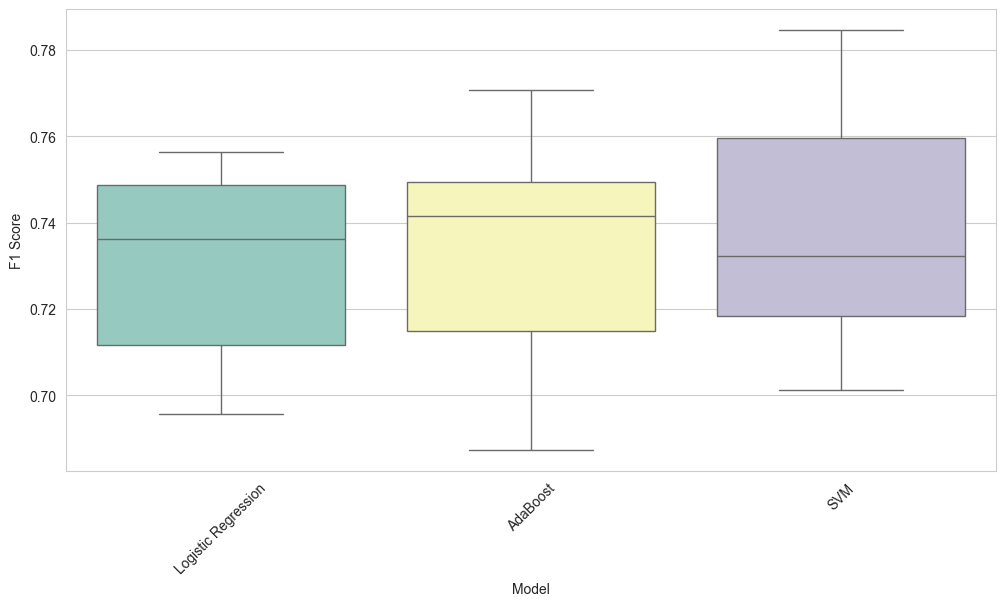

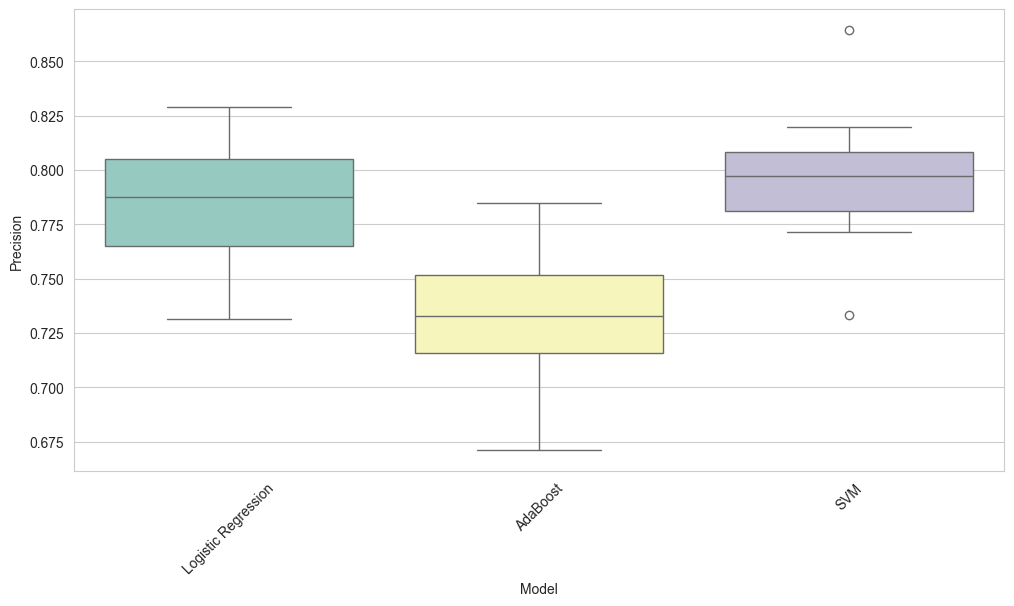

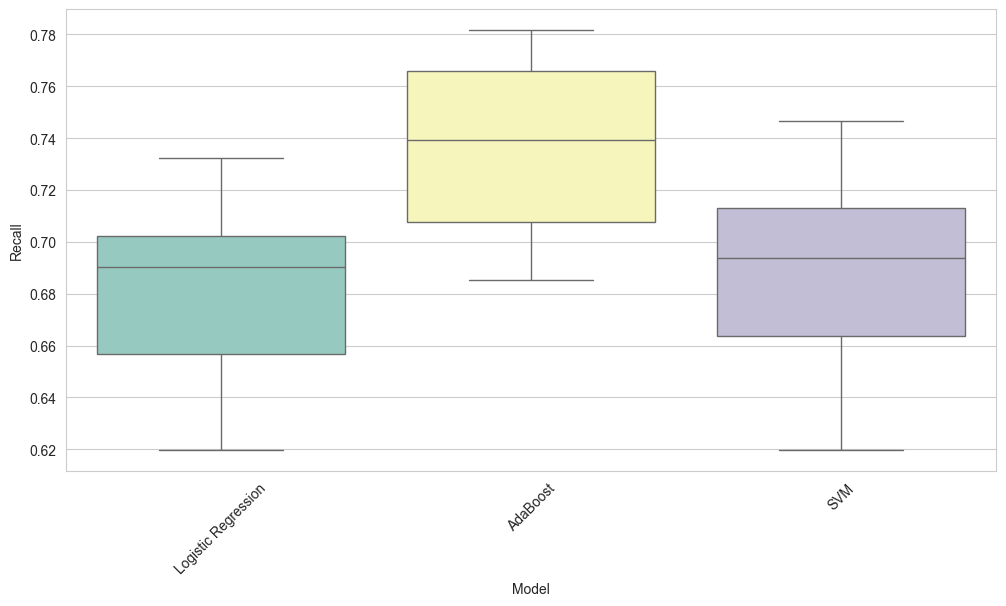

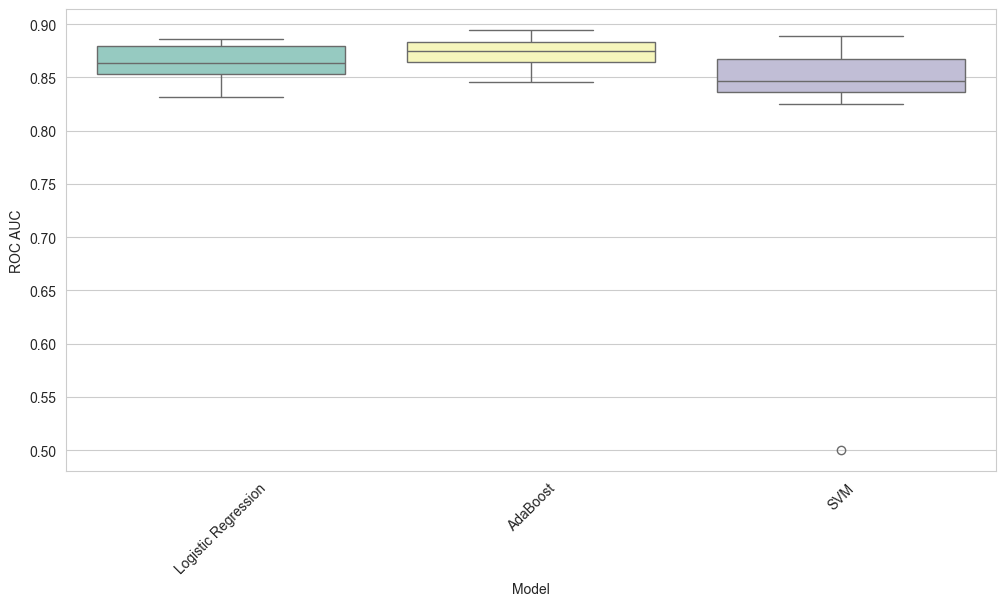

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns

# Boxplot de F1
plt.figure(figsize=(12, 6))
sns.boxplot(data=results_df, x='Model', y='F1 Score', hue='Model', palette='Set3')
plt.xticks(rotation=45)
plt.show()

# Boxplot da precisão
plt.figure(figsize=(12, 6))
sns.boxplot(data=results_df, x='Model', y='Precision', hue='Model', palette='Set3')
plt.xticks(rotation=45)
plt.show()

# Boxplot do recall
plt.figure(figsize=(12, 6))
sns.boxplot(data=results_df, x='Model', y='Recall', hue='Model', palette='Set3')
plt.xticks(rotation=45)
plt.show()

# Boxplot da ROC AUC
plt.figure(figsize=(12, 6))
sns.boxplot(data=results_df, x='Model', y='ROC AUC', hue='Model', palette='Set3')
plt.xticks(rotation=45)
plt.show()


### (old) Seleção de Hiperparams

Selecionando a melhor pipeline de modelagem e realizando uma última otimização, para selecionar os melhores hiperparâmetros a serem usados no modelo final.

In [ ]:
# # Load the dataset
# data = pd.read_csv("../data/clean-dataset.csv")

# X = data.drop('Target', axis=1)
# y = data['Target']

# # Split into training and test sets 
# X_train, X_test, y_train, y_test = train_test_split(X, y, 
#                                                     test_size=0.3, 
#                                                     random_state=42, 
#                                                     stratify=y)

# # Define a function to create the pipeline
# def make_pipeline():
#     steps = [
#         ('Feature Selection', SelectKBest(k=4, score_func=mutual_info_classif)),
#         ('Normalização', StandardScaler()),
#         ('Balanceamento', SMOTE(sampling_strategy='minority', random_state=42)),
#         ('Modelo', AdaBoostClassifier(random_state=0, algorithm='SAMME'))
#     ]
#     pipe = Pipeline(steps=steps)
#     return pipe

# # Define the objective function for Optuna
# def objective(trial):
#     # Define the search space for AdaBoost
#     n_estimators = trial.suggest_int('n_estimators', 50, 500)
#     learning_rate = trial.suggest_float('learning_rate', 0.01, 2.0, log=True)
    
#     # Create the pipeline with the suggested hyperparameters
#     pipeline = make_pipeline()
#     pipeline.set_params(Modelo__n_estimators=n_estimators,
#                         Modelo__learning_rate=learning_rate)
    
#     # Use cross-validation on the entire training set to evaluate the candidate parameters
#     # We'll use StratifiedKFold for a stable estimate of performance.
#     cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
#     scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='f1', n_jobs=-1)
#     return scores.mean()

# # Create and run the Optuna study
# study = optuna.create_study(direction='maximize', study_name='AdaBoost_Optimization')
# study.optimize(objective, n_trials=50, show_progress_bar=True)

# # Print the best parameters found by Optuna
# best_params = study.best_params
# print("Best Parameters:", best_params)

# # Evaluate the best model on the test set
# best_pipeline = make_pipeline()
# best_pipeline.set_params(Modelo__n_estimators=best_params['n_estimators'],
#                          Modelo__learning_rate=best_params['learning_rate'])

# best_pipeline.fit(X_train, y_train)
# y_pred = best_pipeline.predict(X_test)
# y_proba = best_pipeline.predict_proba(X_test)[:, 1]

[I 2024-12-11 20:44:07,509] A new study created in memory with name: AdaBoost_Optimization
Best trial: 0. Best value: 0.725397:   2%|▏         | 1/50 [00:00<00:16,  3.04it/s]

[I 2024-12-11 20:44:07,838] Trial 0 finished with value: 0.7253971999716582 and parameters: {'n_estimators': 243, 'learning_rate': 0.8844591246304463}. Best is trial 0 with value: 0.7253971999716582.


Best trial: 1. Best value: 0.730798:   4%|▍         | 2/50 [00:00<00:13,  3.50it/s]

[I 2024-12-11 20:44:08,093] Trial 1 finished with value: 0.7307979120424518 and parameters: {'n_estimators': 161, 'learning_rate': 0.11870584660744461}. Best is trial 1 with value: 0.7307979120424518.


Best trial: 1. Best value: 0.730798:   8%|▊         | 4/50 [00:01<00:11,  3.87it/s]

[I 2024-12-11 20:44:08,442] Trial 2 finished with value: 0.7288259371708715 and parameters: {'n_estimators': 265, 'learning_rate': 1.5141001242836019}. Best is trial 1 with value: 0.7307979120424518.
[I 2024-12-11 20:44:08,614] Trial 3 finished with value: 0.7286727527160436 and parameters: {'n_estimators': 59, 'learning_rate': 0.3860545662082824}. Best is trial 1 with value: 0.7307979120424518.


Best trial: 1. Best value: 0.730798:  10%|█         | 5/50 [00:01<00:12,  3.62it/s]

[I 2024-12-11 20:44:08,922] Trial 4 finished with value: 0.7261714820336246 and parameters: {'n_estimators': 225, 'learning_rate': 1.056099075643088}. Best is trial 1 with value: 0.7307979120424518.


Best trial: 1. Best value: 0.730798:  12%|█▏        | 6/50 [00:01<00:16,  2.74it/s]

[I 2024-12-11 20:44:09,461] Trial 5 finished with value: 0.7249004240823347 and parameters: {'n_estimators': 479, 'learning_rate': 1.221962045857582}. Best is trial 1 with value: 0.7307979120424518.


Best trial: 6. Best value: 0.730906:  14%|█▍        | 7/50 [00:02<00:18,  2.35it/s]

[I 2024-12-11 20:44:10,010] Trial 6 finished with value: 0.7309062645799577 and parameters: {'n_estimators': 491, 'learning_rate': 0.07390698405486444}. Best is trial 6 with value: 0.7309062645799577.


Best trial: 6. Best value: 0.730906:  16%|█▌        | 8/50 [00:03<00:19,  2.14it/s]

[I 2024-12-11 20:44:10,567] Trial 7 finished with value: 0.730288396428741 and parameters: {'n_estimators': 492, 'learning_rate': 0.09514241572062204}. Best is trial 6 with value: 0.7309062645799577.


Best trial: 6. Best value: 0.730906:  18%|█▊        | 9/50 [00:03<00:17,  2.39it/s]

[I 2024-12-11 20:44:10,876] Trial 8 finished with value: 0.723357554339392 and parameters: {'n_estimators': 240, 'learning_rate': 0.15466462269995335}. Best is trial 6 with value: 0.7309062645799577.


Best trial: 6. Best value: 0.730906:  20%|██        | 10/50 [00:03<00:14,  2.81it/s]

[I 2024-12-11 20:44:11,092] Trial 9 finished with value: 0.6594460069742183 and parameters: {'n_estimators': 122, 'learning_rate': 0.010423832896751974}. Best is trial 6 with value: 0.7309062645799577.


Best trial: 6. Best value: 0.730906:  22%|██▏       | 11/50 [00:04<00:14,  2.61it/s]

[I 2024-12-11 20:44:11,540] Trial 10 finished with value: 0.7275866339038735 and parameters: {'n_estimators': 375, 'learning_rate': 0.019380605048228087}. Best is trial 6 with value: 0.7309062645799577.


Best trial: 11. Best value: 0.7316:  24%|██▍       | 12/50 [00:04<00:15,  2.44it/s] 

[I 2024-12-11 20:44:12,008] Trial 11 finished with value: 0.7316002963353203 and parameters: {'n_estimators': 380, 'learning_rate': 0.05719584940616764}. Best is trial 11 with value: 0.7316002963353203.


Best trial: 11. Best value: 0.7316:  26%|██▌       | 13/50 [00:04<00:15,  2.34it/s]

[I 2024-12-11 20:44:12,478] Trial 12 finished with value: 0.7285015446694798 and parameters: {'n_estimators': 394, 'learning_rate': 0.04127581377341899}. Best is trial 11 with value: 0.7316002963353203.


Best trial: 11. Best value: 0.7316:  28%|██▊       | 14/50 [00:05<00:15,  2.31it/s]

[I 2024-12-11 20:44:12,925] Trial 13 finished with value: 0.7292200646467468 and parameters: {'n_estimators': 390, 'learning_rate': 0.04134063529039582}. Best is trial 11 with value: 0.7316002963353203.


Best trial: 11. Best value: 0.7316:  30%|███       | 15/50 [00:05<00:14,  2.35it/s]

[I 2024-12-11 20:44:13,331] Trial 14 finished with value: 0.7269596675014134 and parameters: {'n_estimators': 330, 'learning_rate': 0.05501559814789252}. Best is trial 11 with value: 0.7316002963353203.


Best trial: 15. Best value: 0.732958:  32%|███▏      | 16/50 [00:06<00:15,  2.26it/s]

[I 2024-12-11 20:44:13,810] Trial 15 finished with value: 0.7329581666638753 and parameters: {'n_estimators': 440, 'learning_rate': 0.2203655829805461}. Best is trial 15 with value: 0.7329581666638753.


Best trial: 16. Best value: 0.733582:  34%|███▍      | 17/50 [00:06<00:15,  2.18it/s]

[I 2024-12-11 20:44:14,310] Trial 16 finished with value: 0.7335815117082338 and parameters: {'n_estimators': 433, 'learning_rate': 0.2519190718706253}. Best is trial 16 with value: 0.7335815117082338.


Best trial: 16. Best value: 0.733582:  36%|███▌      | 18/50 [00:07<00:15,  2.12it/s]

[I 2024-12-11 20:44:14,811] Trial 17 finished with value: 0.7225168549225716 and parameters: {'n_estimators': 437, 'learning_rate': 0.28350151392393563}. Best is trial 16 with value: 0.7335815117082338.


Best trial: 16. Best value: 0.733582:  38%|███▊      | 19/50 [00:07<00:13,  2.24it/s]

[I 2024-12-11 20:44:15,195] Trial 18 finished with value: 0.7239656323395218 and parameters: {'n_estimators': 307, 'learning_rate': 0.43437075357370863}. Best is trial 16 with value: 0.7335815117082338.


Best trial: 19. Best value: 0.734872:  40%|████      | 20/50 [00:08<00:13,  2.15it/s]

[I 2024-12-11 20:44:15,705] Trial 19 finished with value: 0.7348721154221587 and parameters: {'n_estimators': 423, 'learning_rate': 0.20981351532469358}. Best is trial 19 with value: 0.7348721154221587.


Best trial: 19. Best value: 0.734872:  42%|████▏     | 21/50 [00:08<00:13,  2.22it/s]

[I 2024-12-11 20:44:16,121] Trial 20 finished with value: 0.7227580740633289 and parameters: {'n_estimators': 332, 'learning_rate': 0.59624234599682}. Best is trial 19 with value: 0.7348721154221587.


Best trial: 21. Best value: 0.738737:  44%|████▍     | 22/50 [00:09<00:13,  2.13it/s]

[I 2024-12-11 20:44:16,632] Trial 21 finished with value: 0.7387370997547247 and parameters: {'n_estimators': 442, 'learning_rate': 0.2167676369950261}. Best is trial 21 with value: 0.7387370997547247.


Best trial: 21. Best value: 0.738737:  46%|████▌     | 23/50 [00:09<00:12,  2.08it/s]

[I 2024-12-11 20:44:17,143] Trial 22 finished with value: 0.7340428689088467 and parameters: {'n_estimators': 436, 'learning_rate': 0.18104190206898008}. Best is trial 21 with value: 0.7387370997547247.


Best trial: 21. Best value: 0.738737:  48%|████▊     | 24/50 [00:10<00:12,  2.06it/s]

[I 2024-12-11 20:44:17,635] Trial 23 finished with value: 0.7283812255293121 and parameters: {'n_estimators': 443, 'learning_rate': 0.17006731273404502}. Best is trial 21 with value: 0.7387370997547247.


Best trial: 21. Best value: 0.738737:  50%|█████     | 25/50 [00:10<00:11,  2.13it/s]

[I 2024-12-11 20:44:18,072] Trial 24 finished with value: 0.7236263273593904 and parameters: {'n_estimators': 362, 'learning_rate': 0.659638224224863}. Best is trial 21 with value: 0.7387370997547247.


Best trial: 21. Best value: 0.738737:  52%|█████▏    | 26/50 [00:11<00:11,  2.14it/s]

[I 2024-12-11 20:44:18,530] Trial 25 finished with value: 0.724992377104713 and parameters: {'n_estimators': 410, 'learning_rate': 0.37066486380174013}. Best is trial 21 with value: 0.7387370997547247.


Best trial: 21. Best value: 0.738737:  54%|█████▍    | 27/50 [00:11<00:11,  2.04it/s]

[I 2024-12-11 20:44:19,072] Trial 26 finished with value: 0.7365717495609695 and parameters: {'n_estimators': 476, 'learning_rate': 0.18350044108016467}. Best is trial 21 with value: 0.7387370997547247.


Best trial: 21. Best value: 0.738737:  56%|█████▌    | 28/50 [00:12<00:11,  1.99it/s]

[I 2024-12-11 20:44:19,604] Trial 27 finished with value: 0.7272498167228728 and parameters: {'n_estimators': 467, 'learning_rate': 0.10638918239000061}. Best is trial 21 with value: 0.7387370997547247.


Best trial: 21. Best value: 0.738737:  58%|█████▊    | 29/50 [00:12<00:10,  2.09it/s]

[I 2024-12-11 20:44:20,031] Trial 28 finished with value: 0.7290740675716852 and parameters: {'n_estimators': 351, 'learning_rate': 0.5494609080031673}. Best is trial 21 with value: 0.7387370997547247.


Best trial: 29. Best value: 0.741676:  60%|██████    | 30/50 [00:12<00:08,  2.25it/s]

[I 2024-12-11 20:44:20,395] Trial 29 finished with value: 0.7416760172169516 and parameters: {'n_estimators': 297, 'learning_rate': 0.2970943043251736}. Best is trial 29 with value: 0.7416760172169516.


Best trial: 29. Best value: 0.741676:  62%|██████▏   | 31/50 [00:13<00:08,  2.36it/s]

[I 2024-12-11 20:44:20,770] Trial 30 finished with value: 0.730664196429855 and parameters: {'n_estimators': 288, 'learning_rate': 0.7931184505362661}. Best is trial 29 with value: 0.7416760172169516.


Best trial: 29. Best value: 0.741676:  64%|██████▍   | 32/50 [00:13<00:06,  2.63it/s]

[I 2024-12-11 20:44:21,050] Trial 31 finished with value: 0.7331800004817778 and parameters: {'n_estimators': 198, 'learning_rate': 0.30130539898686737}. Best is trial 29 with value: 0.7416760172169516.


Best trial: 29. Best value: 0.741676:  66%|██████▌   | 33/50 [00:14<00:07,  2.39it/s]

[I 2024-12-11 20:44:21,560] Trial 32 finished with value: 0.7344521804758577 and parameters: {'n_estimators': 464, 'learning_rate': 0.13535045236458432}. Best is trial 29 with value: 0.7416760172169516.


Best trial: 29. Best value: 0.741676:  68%|██████▊   | 34/50 [00:14<00:07,  2.28it/s]

[I 2024-12-11 20:44:22,040] Trial 33 finished with value: 0.7295712203977562 and parameters: {'n_estimators': 412, 'learning_rate': 0.22036007646057576}. Best is trial 29 with value: 0.7416760172169516.


Best trial: 29. Best value: 0.741676:  70%|███████   | 35/50 [00:14<00:05,  2.65it/s]

[I 2024-12-11 20:44:22,278] Trial 34 finished with value: 0.7265681367863323 and parameters: {'n_estimators': 143, 'learning_rate': 0.42899798828945535}. Best is trial 29 with value: 0.7416760172169516.


Best trial: 29. Best value: 0.741676:  72%|███████▏  | 36/50 [00:15<00:04,  2.87it/s]

[I 2024-12-11 20:44:22,558] Trial 35 finished with value: 0.7277061008190253 and parameters: {'n_estimators': 191, 'learning_rate': 0.09775645701425095}. Best is trial 29 with value: 0.7416760172169516.


Best trial: 29. Best value: 0.741676:  74%|███████▍  | 37/50 [00:15<00:04,  2.91it/s]

[I 2024-12-11 20:44:22,891] Trial 36 finished with value: 0.7279642800851139 and parameters: {'n_estimators': 264, 'learning_rate': 0.3079016670844525}. Best is trial 29 with value: 0.7416760172169516.


Best trial: 29. Best value: 0.741676:  76%|███████▌  | 38/50 [00:15<00:04,  2.52it/s]

[I 2024-12-11 20:44:23,413] Trial 37 finished with value: 0.7290809981618404 and parameters: {'n_estimators': 456, 'learning_rate': 0.18498182648563646}. Best is trial 29 with value: 0.7416760172169516.


Best trial: 29. Best value: 0.741676:  78%|███████▊  | 39/50 [00:16<00:04,  2.25it/s]

[I 2024-12-11 20:44:23,965] Trial 38 finished with value: 0.7179114130776952 and parameters: {'n_estimators': 497, 'learning_rate': 1.7523439602273085}. Best is trial 29 with value: 0.7416760172169516.


Best trial: 29. Best value: 0.741676:  80%|████████  | 40/50 [00:16<00:03,  2.70it/s]

[I 2024-12-11 20:44:24,162] Trial 39 finished with value: 0.7265087832592162 and parameters: {'n_estimators': 97, 'learning_rate': 0.07793217557699604}. Best is trial 29 with value: 0.7416760172169516.


Best trial: 29. Best value: 0.741676:  82%|████████▏ | 41/50 [00:17<00:03,  2.45it/s]

[I 2024-12-11 20:44:24,662] Trial 40 finished with value: 0.7267710251746056 and parameters: {'n_estimators': 410, 'learning_rate': 0.12870076168921302}. Best is trial 29 with value: 0.7416760172169516.


Best trial: 29. Best value: 0.741676:  84%|████████▍ | 42/50 [00:17<00:03,  2.21it/s]

[I 2024-12-11 20:44:25,215] Trial 41 finished with value: 0.7292011168082195 and parameters: {'n_estimators': 472, 'learning_rate': 0.13697763072741964}. Best is trial 29 with value: 0.7416760172169516.


Best trial: 29. Best value: 0.741676:  86%|████████▌ | 43/50 [00:18<00:03,  2.13it/s]

[I 2024-12-11 20:44:25,727] Trial 42 finished with value: 0.7273163933501745 and parameters: {'n_estimators': 466, 'learning_rate': 0.21889255067524502}. Best is trial 29 with value: 0.7416760172169516.


Best trial: 29. Best value: 0.741676:  88%|████████▊ | 44/50 [00:18<00:02,  2.02it/s]

[I 2024-12-11 20:44:26,279] Trial 43 finished with value: 0.7333362629955195 and parameters: {'n_estimators': 493, 'learning_rate': 0.1373330069142297}. Best is trial 29 with value: 0.7416760172169516.


Best trial: 29. Best value: 0.741676:  90%|█████████ | 45/50 [00:19<00:02,  2.05it/s]

[I 2024-12-11 20:44:26,753] Trial 44 finished with value: 0.7221029800011219 and parameters: {'n_estimators': 415, 'learning_rate': 0.36597847548270385}. Best is trial 29 with value: 0.7416760172169516.


Best trial: 29. Best value: 0.741676:  92%|█████████▏| 46/50 [00:19<00:01,  2.01it/s]

[I 2024-12-11 20:44:27,269] Trial 45 finished with value: 0.7334537020322615 and parameters: {'n_estimators': 453, 'learning_rate': 0.4920707630138048}. Best is trial 29 with value: 0.7416760172169516.


Best trial: 29. Best value: 0.741676:  94%|█████████▍| 47/50 [00:20<00:01,  1.96it/s]

[I 2024-12-11 20:44:27,813] Trial 46 finished with value: 0.731303822345535 and parameters: {'n_estimators': 478, 'learning_rate': 0.08019341742185498}. Best is trial 29 with value: 0.7416760172169516.


Best trial: 29. Best value: 0.741676:  96%|█████████▌| 48/50 [00:20<00:01,  1.97it/s]

[I 2024-12-11 20:44:28,312] Trial 47 finished with value: 0.7277903529394225 and parameters: {'n_estimators': 423, 'learning_rate': 1.2004736084501162}. Best is trial 29 with value: 0.7416760172169516.


Best trial: 29. Best value: 0.741676:  98%|█████████▊| 49/50 [00:21<00:00,  2.04it/s]

[I 2024-12-11 20:44:28,761] Trial 48 finished with value: 0.7226789445721156 and parameters: {'n_estimators': 393, 'learning_rate': 0.05959507292012681}. Best is trial 29 with value: 0.7416760172169516.


Best trial: 29. Best value: 0.741676: 100%|██████████| 50/50 [00:21<00:00,  2.31it/s]


[I 2024-12-11 20:44:29,199] Trial 49 finished with value: 0.7294342165936305 and parameters: {'n_estimators': 363, 'learning_rate': 0.2533042783509203}. Best is trial 29 with value: 0.7416760172169516.
Best Parameters: {'n_estimators': 297, 'learning_rate': 0.2970943043251736}


# 2. Avaliação final (novo)

In [ ]:
# Print the best parameters found by Optuna
best_params = study.best_params
print("Best Parameters:", best_params)

# Evaluate the best model on the test set
best_pipeline = make_pipeline()
best_pipeline.set_params(Modelo__n_estimators=best_params['n_estimators'],
                         Modelo__learning_rate=best_params['learning_rate'])

best_pipeline.fit(X_train, y_train)
y_pred = best_pipeline.predict(X_test)
y_proba = best_pipeline.predict_proba(X_test)[:, 1]

In [ ]:
final_results = {
    'F1 Score': f1_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'ROC AUC': roc_auc_score(y_test, y_proba)
}
print("Final Evaluation on Test Set:", final_results)

# # (Optional) Visualizations for the study
# from optuna.visualization import plot_optimization_history, plot_slice, plot_parallel_coordinate, plot_contour, plot_param_importances

# fig_opt_history = plot_optimization_history(study)
# fig_opt_history.show()

# fig_slice = plot_slice(study)
# fig_slice.show()

# fig_parallel = plot_parallel_coordinate(study)
# fig_parallel.show()

# fig_contour = plot_contour(study)
# fig_contour.show()

# fig_param_importances = plot_param_importances(study)
# fig_param_importances.show()

# display(final_results)

Final Evaluation on Test Set: {'F1 Score': np.float64(0.7528344671201814), 'Precision': np.float64(0.7296703296703296), 'Recall': np.float64(0.7775175644028103), 'ROC AUC': np.float64(0.8864220603180957)}


{'F1 Score': np.float64(0.7528344671201814),
 'Precision': np.float64(0.7296703296703296),
 'Recall': np.float64(0.7775175644028103),
 'ROC AUC': np.float64(0.8864220603180957)}

C:\Users\Matheus\AppData\Local\Temp\ipykernel_10056\511959001.py:11: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




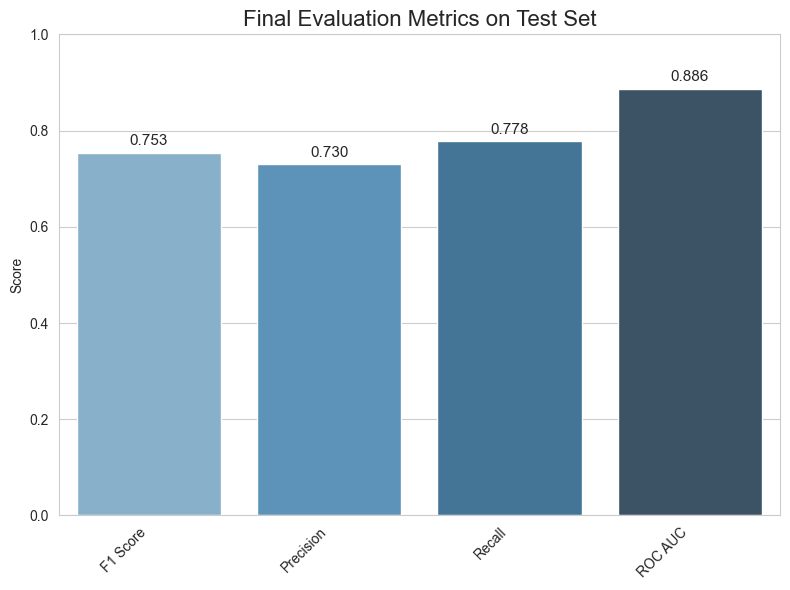

In [75]:
# Convert final_results into a DataFrame for easy plotting
final_results_df = pd.DataFrame(list(final_results.items()), columns=['Metric', 'Value'])

# Set a style for seaborn
sns.set_style("whitegrid")

# Create a figure and axes
plt.figure(figsize=(8, 6))

# Plot the bar chart
sns.barplot(x='Metric', y='Value', data=final_results_df, palette='Blues_d')

# Add labels and title
plt.title("Final Evaluation Metrics on Test Set", fontsize=16)
plt.ylim(0, 1.0)
for index, row in final_results_df.iterrows():
    plt.text(index, row['Value'] + 0.01, f"{row['Value']:.3f}", 
             ha='center', va='bottom', fontsize=11)

plt.xlabel("")
plt.ylabel("Score")
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

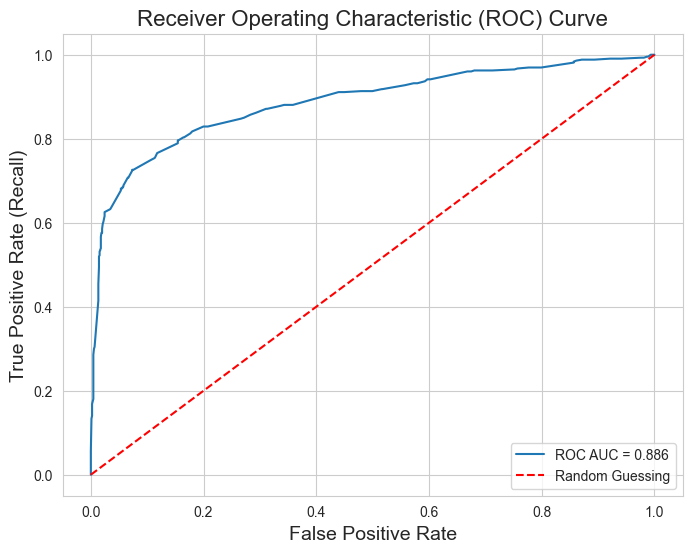

In [76]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC AUC = {final_results['ROC AUC']:.3f}")
plt.plot([0, 1], [0, 1], 'r--', label="Random Guessing")

plt.title("Receiver Operating Characteristic (ROC) Curve", fontsize=16)
plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate (Recall)", fontsize=14)
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

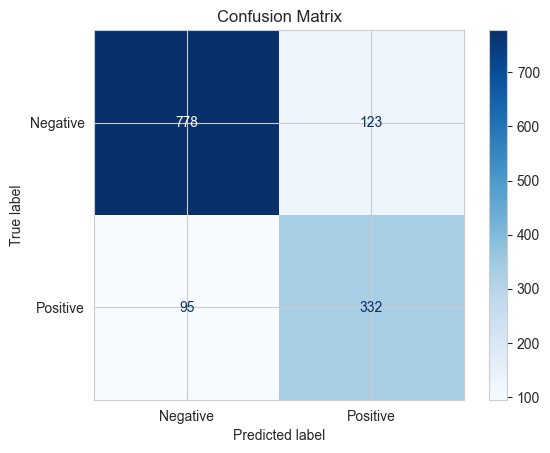

In [77]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate predictions
y_pred = best_pipeline.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot using the built-in confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()